# A Brief Implementation of Newtonian Fractals

...and a tool to make your own, too!

### Necessary packages

You are going to need to pip install **numpy**, **pillow**, and **ray**. 

You are probably familiar with Numpy, and today we will be using it for its representation of polynomials and complex numbers. It is by far the fastest implementation of these things I could find (before I was using this, I was using Sympy. Though it was very user friendly, it was much too slow.)

Pillow is a library that allows us to create a manipulate images. This is what we will actually use to create our image file.

Ray is a library that allows us to create multiple processes / asyncronous functions. This will make our calculations much faster than if it were to be done syncronously.

I also imported warnings to disable certain warnings *(personal preference)* and timeit to see how long our calculations take.


In [64]:
from numpy.polynomial import *
from numpy import *
import ray
from PIL import Image
import warnings
from timeit import default_timer as timer
warnings.filterwarnings('ignore')
ray.init(ignore_reinit_error=True)

2021-10-14 10:15:48,860	INFO worker.py:836 -- Calling ray.init() again after it has already been called.


### Defining Important Global Variables

`MAX_ITER` is simply the amount of iterations we want to repeat using Newton's method on each input. As `MAX_ITER` increases more exact the image is. However, the program needs to make more calculations and it will take longer. I found `MAX_ITER = 8` to be a healthy balance, but this can vary depending on whichever polynomial you pick.

In [65]:
MAX_ITER = 20

`POLY_COEF` is a list of our polynomial's coefficients. Each index corresponds to the degree of the term. You can see this below in the next step (if you do not want the term in your polynomial, set it's coefficient to 0).

In [66]:
POLY_COEF = [90, 1, -4, -90, -16, 25, -16, 9, -4, 1, 0]
POLY_COEF

[0, 1, -4, 9, -16, 25, -36, 49, -64, 81, -100]

`POLY` is our representation of our polynomial. As apposed to the list `POLY_COEF`, we can actually plug numbers into `POLY_COEF` with parentheses (i.e. `POLY(2)`).

In [67]:
POLY = Polynomial(POLY_COEF)
POLY

Polynomial([   0.,    1.,   -4.,    9.,  -16.,   25.,  -36.,   49.,  -64.,
         81., -100.], domain=[-1,  1], window=[-1,  1])

`ROOTS` is the array of actual roots of our polynomial. When we eventually try to approximate the polynomial via newton's method, we will approach some of these. We include `None` at the start for later use (some numbers will make us divide by 0).

In [68]:
ROOTS = [None] + list(POLY.roots())
ROOTS

[None,
 (-0.48487746912027757-0.49414006970125685j),
 (-0.48487746912027757+0.49414006970125685j),
 (-0.09514370686299237-0.6175487749335118j),
 (-0.09514370686299237+0.6175487749335118j),
 0j,
 (0.25198447553029213-0.523094648780017j),
 (0.25198447553029213+0.523094648780017j),
 (0.4677344554105124-0.2828105985693799j),
 (0.4677344554105124+0.2828105985693799j),
 (0.5306044900849274+0j)]

`GRADIENT` will be the derivative of our poly. This will be another numpy polynomial, just with a slightly lower degree.

In [69]:
GRADIENT = POLY.deriv()
GRADIENT

Polynomial([    1.,    -8.,    27.,   -64.,   125.,  -216.,   343.,  -512.,
         729., -1000.], domain=[-1.,  1.], window=[-1.,  1.])

### Using Newton's Method

First we are going to make the recursive function that repeatedly applies Newton's method; `root_approx_util`. This will take a complex number, `curr_x`, and a iteration counter, `curr_iter`.

Every iteration, we are first going to check if we reached the maximum iterations. If we have, we will return the `curr_x` passed to us. 

If we have not reached the final iteration, we are going to try to find `new_x`. To do this, we solve for the x intercept of a tangent line. The tangent line will have a derivative as it's slope and pass through the given point on the polynomial. To find the x intercept we need to utilize basic algebra.

If we get an answer, we are going to recursively input `new_x` back into our function. However, we must increment `curr_iter` by one.

I had to surround this in a try catch block because sometimes, if the slope at a certain point is 0, we will have to divide by 0. When this happened, I chose to immediately return `None`.

In [70]:
def root_approx_util(curr_x, curr_iter):
    if curr_iter is MAX_ITER:
        return curr_x
    else:
        try:
            new_x = curr_x - (POLY(curr_x)/GRADIENT(curr_x))
            return root_approx_util(new_x, curr_iter+1)
        except:
            return None

When using `root_approx_util`, our answer is inexact or it can possibly not exist. To circumvent this, we map each approximate root to the index of our actual root in the list `ROOTS`. This is what the `root_approx_ind` is for.

When first given some complex number x, we find the approximate root using `root_approx_util`. We pass 0 into `curr_iter` because we did not complete any iterations yet. If this returns `None` we simply return 0, as the first entry in 'ROOTS' is 'None'. 

Then, we are going to find which root on our list this is closest to. We do this by finding the difference between each of our roots in `ROOTS` (excluding the first entry, which is `None`). To find the distance (squared, as sqrt is unnecessary if we are only comparing distances), we multiply this distance by its own conjugate. If this distance is less than the lowest distance so far, we record it in `best_ind_dist_sq` and we record it's index in `best_ind`. When done looping, we return `best_ind`.

In [71]:
def root_approx_ind(x):
    approx_root = root_approx_util(x, 0)
    if approx_root is None:
        return 0
    best_ind = 0
    best_ind_dist_sq = float("inf")
    for i in range(1, len(ROOTS)):
        diff = ROOTS[i] - approx_root
        curr_dist_sq = diff * conjugate(diff)
        if curr_dist_sq < best_ind_dist_sq:
            best_ind_dist_sq = curr_dist_sq
            best_ind = i
    return best_ind

### Image Settings

`WIDTH` and `HEIGHT` are the dimensions of the image (in pixels). `R_BOUNDS` and `I_BOUNDS` is the range in which we are going to draw the real and imaginary axes. If the length of these ranges and the dimensions of the actual image are off, the resulting photo will be stretched.

`R_INC` and `I_INC` is are the ratios between pixels vs complex numbers. In this case, `R_INC` and `I_INC` are both 200, meaning that a distance of one in both the real and imaginary directions each correspond to 200 pixels.

`R_CENTER` and `I_CENTER` both represent the midpoints of each range. These variables simply exist to make later calculations easier to read.

In [72]:
WIDTH = 250
HEIGHT = 250

R_BOUNDS = (-1, 1)
I_BOUNDS = (-1, 1)

R_INC = WIDTH/(R_BOUNDS[1] - R_BOUNDS[0])
I_INC = HEIGHT/(I_BOUNDS[1] - I_BOUNDS[0])

R_CENTER = sum(R_BOUNDS)/2
I_CENTER = sum(I_BOUNDS)/2

`COLORS` is an array of RGB colors that each correspond to a given root. I gave the index of 0 black, and used some random group of colors I found online for the rest. Feel free to change these too your liking, but just make sure that `len(COLORS) >= len(ROOTS)`

*I also implemented a color interpolator instead of the list of colors because they look cooler. It is really personal preference.*

In [73]:
#COLORS = [(0,0,0),(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),(43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),(194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),(224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(255,80,5)]

COLORS = [(0,0,0)]
COMP1 = (232, 148, 14)
COMP2 = (14, 61, 232)
COLOR_QUANT = len(ROOTS)-1
for i in range(0, COLOR_QUANT+1):
    MIXED_COLOR = [0,0,0]
    for ind in range(0, 3):
        MIXED_COLOR[ind] = int(((COLOR_QUANT-i)*COMP1[ind] + i*COMP2[ind])/(COLOR_QUANT))
    COLORS += [tuple(MIXED_COLOR)]

COLORS

[(0, 0, 0),
 (232, 148, 14),
 (210, 139, 35),
 (188, 130, 57),
 (166, 121, 79),
 (144, 113, 101),
 (123, 104, 123),
 (101, 95, 144),
 (79, 87, 166),
 (57, 78, 188),
 (35, 69, 210),
 (14, 61, 232)]

`BORDERS` is a boolean which asks if we want borders between regions. `BORDER_WIDTH` is the width of this border in pixels (if `BORDERS` was true).

In [74]:
BORDERS = False
BORDER_WIDTH = 1

`IMG` will be our pillow image object. Our program can edit this as we please.

In [75]:
IMG = Image.new('RGB', (WIDTH, HEIGHT))

To do calculations, we must convert the points of pixels on our image (`img_point`) to actual mathmatical points (`point`). The method `img_point_to_point` does this. All we need to do is utilize some *shifty* math using the constants we defined above.

In [76]:
def img_point_to_point(img_point):
    return ((img_point[0] - WIDTH/2)/R_INC + R_CENTER, (img_point[1] - HEIGHT/2)/I_INC + I_CENTER)

### Putting Everything Together (Using Ray)

We are almost done. However, we need to actually do these calculations. Albeit seemingly simple, this will take a large amount number plugging in. To speed things up, we need to use multiprocessing. Instead of doing every task in order (lets say calculate the colors in a column), we need to want to do these calculations simulataneously.

Ray lets us do that. By putting the `@ray.remote` decorator over a function, we can allow this function to run asyncronously. The function at first will return a future, but eventually this future will be resolved to an actual value.

The `calc_col` function does what it says; it calculates the given colors (in the form of indexes to the `COLORS` list) for all of the points for a given x (a column). We do that by looping through an array, giving us a set of different points of the pixels on the image. By using the `img_point_to_point` method, we can turn this into a mathimatical point. Then, by using numpy's `complex` class, we can convert this into a complex number. Then we can plug this number into the `root_approx_ind` and than push it too our column list (`res`).

In [77]:
@ray.remote
def calc_col(x):
    res = []
    for y in range(0, HEIGHT):
        point = img_point_to_point((x,y))
        complex_num = complex(real=point[0], imag=point[1])
        res.append(root_approx_ind(complex_num))
    return res

While we are defining methods to create our final image, we can make a method that creates borders. This will be the `create_borders` method. Here, we are going to take a 2D array of all the pixel color's, `grid` (something we will create later). Then, we check for points on the grid that border a color which is different then its own. Then we set it's color index to 0, (which is black). We iterate this more and more times to increase the thickness of the line. 

It should be noted that this calculation cannot be done in place. If we were to do that, we would endlessly increase the thickness of one of our lines, filling the entire image. 

It should also be noted that even when the width is one, the lines will appear quite thick. This is basically painting over the bits of the fractal with the most detail. This is why I don't like this mode as it comes at the cost of so much detail.


In [78]:
def create_borders(grid):
    curr_grid = grid
    for i in range(0, BORDER_WIDTH):
        new_grid = [row[:] for row in curr_grid]
        for x in range(1, WIDTH-1):
            for y in range(1, HEIGHT-1):
                cont1 = curr_grid[x][y] == curr_grid[x+1][y]
                cont2 = curr_grid[x][y] == curr_grid[x][y+1]
                cont3 = curr_grid[x][y] == curr_grid[x-1][y]
                cont4 = curr_grid[x][y] == curr_grid[x][y-1]
                if not (cont1 and cont2 and cont3 and cont4):
                    new_grid[x][y] = 0
        curr_grid = new_grid
    return curr_grid

Now we can finally combine this all to make our image!!! Optionally, I implemented a timer to see how long this program would take.

First, we make a list to store all of the promises/futures we get from `calc_col`. I denotatively called this list `futures`. Then we loop through at the pixel x values in our image. When we do this, we append a new future to the list from `calc_col`. Instead of calling this method directly, we use and pass our x into `.remote()` so Ray can run this asyncronously for us.

After we are done looping, we wait for our futures to be converted into usable values. We use `ray.get(futures)` for this. When this is resolved, we get a 2D array that contains the correct color index for each pair of x and y. For example, the correct color of the pixel `(62, 49)` would be `grid[62][49]`.



Once we have this grid, we can loop through each x and y. For each x and y, we fill in the corresponding pixel with the `putpixel` method. To do this, we pass a tuple representing the point and the color we want (indexed using our calculated grid).

Now we can display our results!!! :D

Starting calculations...
Math done, creating image...
Image done calculating! (1738.2084282000005 seconds)


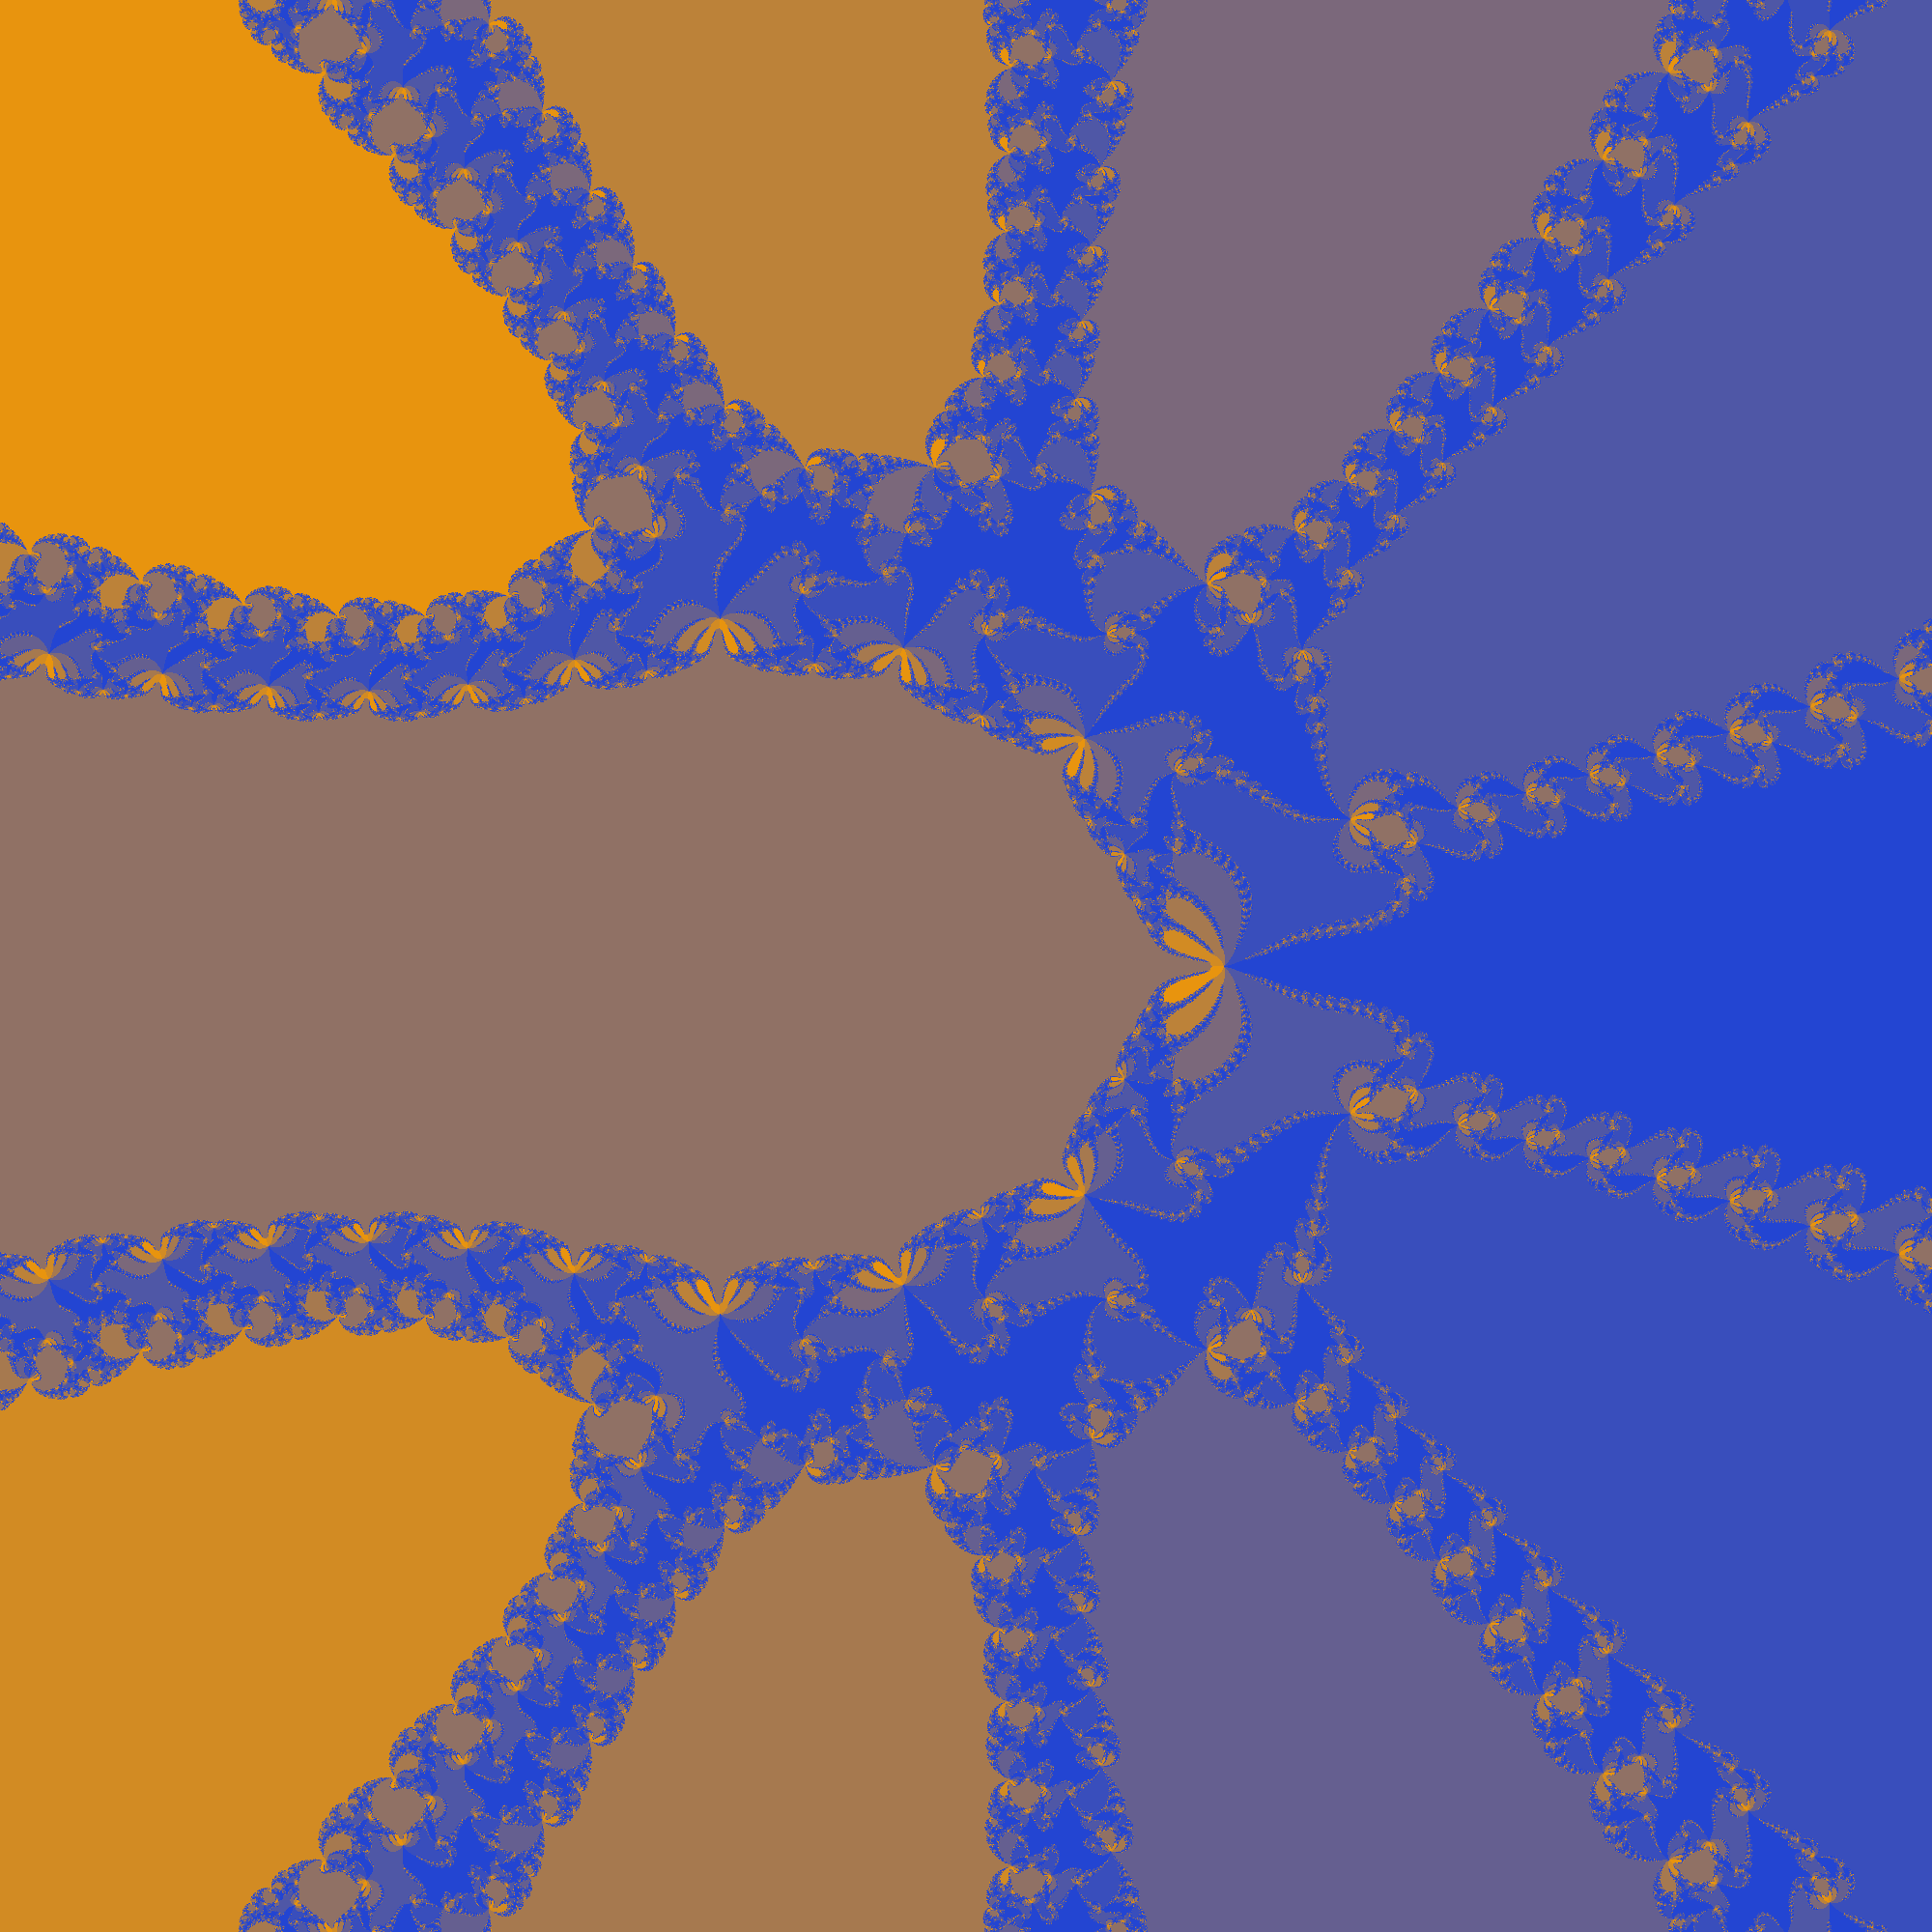

In [79]:
print("Starting calculations...")
start = timer()

futures = []
for x in range(0, WIDTH):
    futures.append(calc_col.remote(x))
grid = ray.get(futures)

if (BORDERS):
    print("Creating borders...")
    grid = create_borders(grid)
                    
print("Math done, creating image...")
for x in range(0, WIDTH):
    for y in range(0, HEIGHT):
        IMG.putpixel((x, y), COLORS[grid[x][y]])
        
end = timer()
print("Image done calculating! ({} seconds)".format(end-start))
IMG

### Saving The Image

If your want your can save your image we can use the `Image` classes inbuilt `save` function. This will save your image to the same directory as this notebook. You can obviously change were it saves by passing another directory into this function.

I made it so that the file name contains the polynomial's coefficients as well as the range in which the fractal is shown.

In [80]:
FILE_NAME = (str(POLY_COEF) + str(list(R_BOUNDS)) + str(list(I_BOUNDS)) + ".png").replace(" ", "")
print(FILE_NAME)
IMG.save(FILE_NAME)

[0,1,-4,9,-16,25,-36,49,-64,81,-100][-1,1][-1,1].png


## Possible Variations

Thanks for reading this notebook to the very bottom. Feel free to play around and show me some of the fractals you have made. If there is a way to make this faster, please explain what I am doing wrong. Some online implementations do this mind bogglingly fast ([like this one](http://usefuljs.net/fractals/docs/newtonian_fractals.html)).

Also, the scaffolding made here can be easily extended to make some other complex plane fractals (like the Mandelbrot and Julia sets). I would like to see a fork where somebody makes those fractals!